In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
### 2.2 Dimensionality reduction via optimization (DRO)
class DRO:

    def __init__(self):
        self.Z = None # n x d
        self.A = None # D x d
        self.b = None # D x 1
        # a singular point x_i is reconstructed by x_i = A*z_i + b

    def train(self, X, d): 
        # X is n x D
        self.b = np.mean(X, axis=0)
        X_demeaned = np.copy(X) - self.b
        U, S, Vh = np.linalg.svd(X_demeaned)
        self.A = Vh[:d]
        self.Z = np.matmul(X_demeaned, self.A.T) 
        return (U,S,Vh)

    def reconstruct(self):
        return np.matmul(self.Z, self.A) + np.outer(np.ones(len(self.Z)), self.b)

# model_DRO = DRO()
# U,S,Vh = model_DRO.train(data_2D, 1)
# print(f'U= \n{U}, \nS=\n{S}, \nVh=\n{Vh})')
# print(f'A={model_DRO.A}')
# print(f'Original points=\n{data_2D[:3]}')
# print(f'Reconstructed points=\n{model_DRO.reconstruct()[:3]}')

In [9]:
### 2.3 Experiment

### Implementation of 3 PCA methods

DEBUG_PCA = False

variant_names = ['buggy', 'demeaned', 'normalized']
class PCA:

    def __init__(self):
        self.Z = None
        self.V = None
        self.mean = None
        self.std = None
        self.mrv = None # most revent variant

    def train(self, X, d, variant='buggy'):
        self.mrv = variant
        # Function takes a n x D data matrix and d as an argument.
        # It should return the d dimensional representations, the estimated parameters, and the reconstructions of these representations in D dimensions.
        if self.mrv == 'demeaned' or self.mrv == 'normalized':
            # "We subtract the mean along each dimension before applying PCA."
            self.mean = np.mean(X, axis=0)
            X -= self.mean
            if DEBUG_PCA:
                print(f'self.mean={self.mean}')
        
        if self.mrv == 'normalized':
            self.std = np.std(X, axis=0)
            X /= self.std
            if DEBUG_PCA:
                print(f'self.std={self.std}')

        if DEBUG_PCA:
            print(f'Data after initial transformations:')
            print(X[:3])
        
        X_k = np.copy(X)
        if DEBUG_PCA:
            print(f'X_k.shape={X_k.shape}')
        v = []
        for i in range(d):
            matrix_gram = np.matmul(X.T, X)
            eigval, eigvec = np.linalg.eig(matrix_gram)
            idx_vec = np.argmax(eigval)
            vec_max = eigvec[:,idx_vec]
            v.append(vec_max)

            X_k = X_k - np.matmul(X, np.outer(vec_max, vec_max.T))
        self.V = np.array(v)
        if DEBUG_PCA:
            print(f'V.shape={self.V.shape}')

        # store original X points in their Z representation
        # each x_i is 1 x D, so X is n x D
        # each v_j is 1 x D, so V is d x D
        # we want Z which is n x d
        # so we must do Z = X * V^T
        self.Z = np.matmul(X, self.V.T)
        if DEBUG_PCA:
            print(f'Z.shape={self.Z.shape}')

    def reconstruct(self, variant=None):
        # variant = self.mrv

        # Z is an n x d matrix
        # V is a d x D matrix
        # we want a n x D matrix, hence we must do r = Z @ V
        r =  np.matmul(self.Z, self.V)

        if self.mrv == 'normalized':
            r *= self.std
        if self.mrv == 'demeaned' or self.mrv == 'normalized':
            r += self.mean
        
        return r

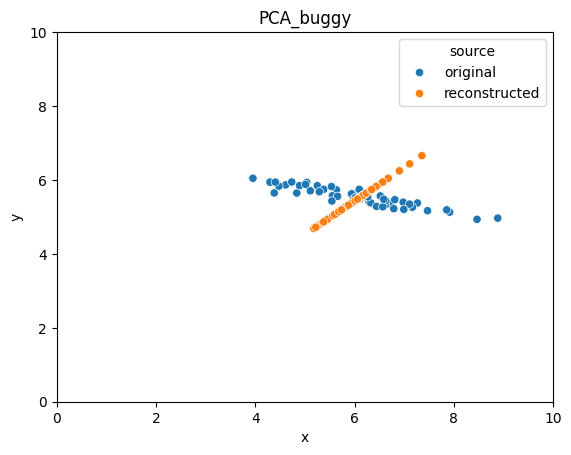

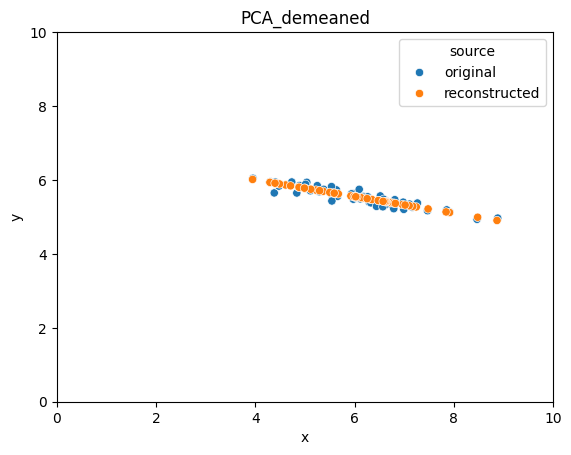

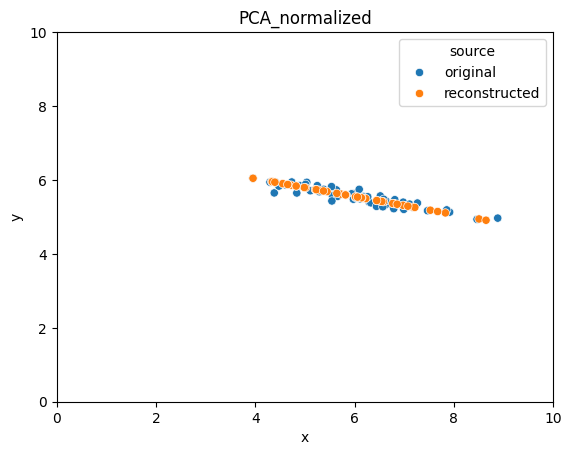

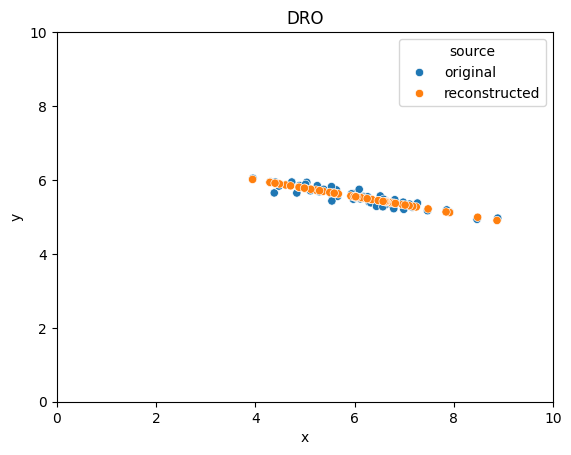

In [4]:
### 2.3.3 Plots showing original points and reconstructed points for 2D dataset for each one of the 4 methods

data_2D = np.loadtxt('data/data2D.csv', delimiter=",")

method_models = [(PCA(), 'PCA', v) for v in variant_names]
method_models.append((DRO(), 'DRO', None))
for model, method, variant in method_models:
    # print(f'\nFor method {method}, variant {variant} we have')
    
    # print('First, we train')
    path = ''
    if variant is None:
        model.train(np.copy(data_2D), 1)
        title = f'{method}'        
    else:
        model.train(np.copy(data_2D), 1, variant=variant)
        title = f'{method}_{variant}'
    path = f'{title}.png'
    
    # print(f'V={model_PCA.V},\nZ={model_PCA.Z[:3]}')
    # print('Then, we reconstruct')
    data_reconstructed = model.reconstruct()

    points_combined = np.concatenate((data_2D, data_reconstructed), axis=0)
    # print('points_combined')
    # print(points_combined)
    df = pd.DataFrame(points_combined, columns=['x', 'y'])
    source = ['original' for _ in range(len(data_2D))]
    source.extend(['reconstructed' for _ in range(len(data_2D))])
    df['source'] = source
    # print(df)
    fig, ax = plt.subplots()
    ax.set_xlim(left=0, right=10)
    ax.set_ylim(bottom=0, top=10)
    sb.scatterplot(data=df, x="x", y="y", hue="source", ax=ax).set(title=title)
    plt.savefig(path)

In [31]:
def error_reconstruction(points_original, points_reconstructed):
    # returns froebius norm (i.e. sum of squared differences per element in X - x_reconstructed)
    num_binted = 3
    diff = points_original - points_reconstructed
    diff_norm = np.linalg.norm(diff, axis=1)
    diff_norm_sq = diff_norm*diff_norm
    sum_diff = sum(diff_norm_sq)
    # print(diff[:num_binted])
    # print(diff_norm[:num_binted])
    # print(diff_norm_sq[:num_binted])
    # print(sum_diff)
    return sum_diff

data_2D = np.loadtxt('data/data2D.csv', delimiter=",")
data_1000D = np.loadtxt('data/data1000D.csv', delimiter=",")

datasets = { 'data_2D':data_2D, 'data_1000D':data_1000D }
tab = { dataset_name: { 'Method':[], 'Reconstruction Error':[] } for dataset_name in datasets.keys() }
method_models = [(PCA(), 'PCA', v) for v in variant_names]
method_models.append((DRO(), 'DRO', None))
for dataset_name, d in datasets.items():
    for model, method, variant in method_models:
        data = np.copy(d)
        print(f'\nFor data {dataset_name}, method {method}, variant {variant} we have')
        
        desired_dimension = 1 if dataset_name == 'data_2D' else 30

        if variant is None:
            model.train(data, desired_dimension)
            title = f'{method}'        
        else:
            model.train(data, desired_dimension, variant=variant)
            title = f'{method}_{variant}'

        # print(model.mrv)
        data_reconstructed = model.reconstruct()
        # print(model.Z[:3])
        # print(data_reconstructed[:3])

        e = error_reconstruction(np.copy(d), np.copy(data_reconstructed))
        tab[dataset_name]['Method'].append(title)
        tab[dataset_name]['Reconstruction Error'].append(e)
        # print('Reconsturction error:')
        # print(e)

# for dataset_name, t in tab.items():
#     # print(t)

In [32]:
### plot values in tables for each dataset
df_error_2D = pd.DataFrame(tab['data_2D'])
df_error_1000D = pd.DataFrame(tab['data_1000D'])

In [33]:
df_error_2D

,Method,Reconstruction Error
0,PCA_buggy,44.345154
1,PCA_demeaned,0.500304
2,PCA_normalized,2.473604
3,DRO,0.500304


In [ ]:
df_error_1000D

In [27]:
tab_f = {'dim':[], 'error':[]}
max_dim = 100
for i in range(1,max_dim):
    data = np.copy(data_1000D)
    model_DRO = DRO()
    model_DRO.train(data_1000D, i)
    data_r = model_DRO.reconstruct()
    e = error_reconstruction(np.copy(data), np.copy(data_r))
    print(f'i={i}, e={e}')
    tab_f['dim'].append(i)
    tab_f['error'].append(e)

i=1, e=14010680.606413528
i=2, e=13201855.250281971
i=3, e=12468988.647470225
i=4, e=11794742.548262898
i=5, e=11120796.931075277
i=6, e=10465142.188867897
i=7, e=9859411.495268892
i=8, e=9289767.063479792
i=9, e=8724224.97928016
i=10, e=8175225.266770904
i=11, e=7631596.415302614
i=12, e=7105511.26905324
i=13, e=6610297.379066957
i=14, e=6135268.830261253
i=15, e=5665074.184607367
i=16, e=5201213.091543032
i=17, e=4751442.876750411
i=18, e=4315309.244538645
i=19, e=3890410.2017668746
i=20, e=3479080.7675879253
i=21, e=3079185.0022470546
i=22, e=2702355.491715163
i=23, e=2335279.4180347254
i=24, e=1982952.503744599
i=25, e=1648466.9871240694
i=26, e=1322004.7609096605
i=27, e=1005163.4934846191
i=28, e=694317.7392336074
i=29, e=401527.6188019803
i=30, e=136522.97948930145
i=31, e=135697.80211063693
i=32, e=134884.8637545237
i=33, e=134089.85211368653
i=34, e=133302.71038546247
i=35, e=132518.75848798596
i=36, e=131746.89452552304
i=37, e=130979.50690226883
i=38, e=130221.67786353503
i=

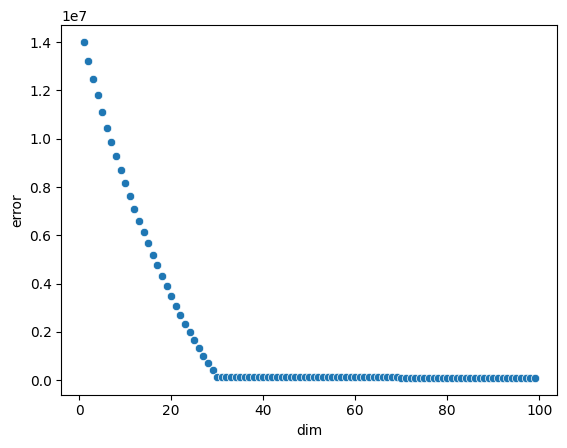

In [30]:
df_test = pd.DataFrame(tab_f)
df_test
# data_1000D = np.loadtxt('data/data1000D.csv', delimiter=",")
# .set(title=title)
sb.scatterplot(data=df_test, x="dim", y="error")
plt.savefig('choice_of_d.png')